<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/MYRBM_EBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

In [5]:
!nvidia-smi

Fri Nov 15 08:51:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   48C    P8              17W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


# Hyperparameters (adjust these during hyperparameter tuning)
num_epochs = 100
k = 10  # Increased CD-k
num_visible = 784
num_hidden = 1000  # Corrected number of hidden units
learning_rate = 1e-5  # Further lowered learning rate
alpha = 0.01
weight_decay = 1e-3  # Increased weight decay further
momentum = 0.9
clip_value = 1.0
patience = 15  # Increased patience

# Data augmentation transforms (consider simplifying if needed)
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Reduced rotation angle
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Define datasets and dataloaders
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

validation_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

# Define the RBM model with dropout
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(num_visible))
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))
        self.dropout = nn.Dropout(p=0.5)  # Added dropout layer

    def sample_h(self, v):
        p_h_given_v = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        p_h_given_v = self.dropout(p_h_given_v)  # Apply dropout
        p_h_given_v = torch.clamp(p_h_given_v, 0, 1)  # Clamp the probabilities
        return torch.bernoulli(p_h_given_v)

    def sample_v(self, h):
        p_v_given_h = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return torch.bernoulli(p_v_given_h)

    def energy(self, v, h):
        vWh = torch.matmul(torch.matmul(v, self.W.t()), h.t())
        return -torch.sum(vWh) - torch.matmul(v, self.v_bias) - torch.matmul(h, self.h_bias)

    def forward(self, v, k=1):
        h = self.sample_h(v)
        for _ in range(k):
            v_recon = self.sample_v(h)
            h = self.sample_h(v_recon)
        return v_recon, h

# Define the RBM model
model = RBM(num_visible, num_hidden)

# Define the optimizer with momentum and learning rate scheduling
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)  # Changed to ReduceLROnPlateau

# Define the loss function (consider adding L1 regularization)
def calculate_loss(v, v_recon, model, h):
    reconstruction_loss = torch.mean(model.energy(v, h) - model.energy(v_recon, h))
    regularization_loss = alpha * torch.mean(model.energy(v, h))
    # Add L1 regularization if needed:
    # l1_loss = some_weight * torch.sum(torch.abs(model.W))
    # return reconstruction_loss + regularization_loss + l1_loss
    return reconstruction_loss + regularization_loss

# Training loop with early stopping and gradient clipping
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []  # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            v_recon, h = model(data, k=k)

            loss = calculate_loss(data, v_recon, model, h)
            epoch_loss += loss.item()

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

    #scheduler.step(val_loss)  # Update learning rate based on validation loss

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)  # Append training loss
    print(f"Epoch {epoch+1}: Average Training Loss = {avg_epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in validation_loader:
            data = data.view(data.size(0), -1)
            v_recon, h = model(data, k=k)
            val_loss += calculate_loss(data, v_recon, model, h).item()
    val_loss /= len(validation_loader)

    #scheduler.step(val_loss)
    val_losses.append(val_loss)  # Append validation loss
    print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")

    scheduler.step(val_loss)  # Call scheduler AFTER optimizer.step


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch 1: 100%|██████████| 938/938 [01:27<00:00, 10.74batch/s, loss=-2.24e+4]


Epoch 1: Average Training Loss = -27790.0176
Epoch 1: Validation Loss = -23469.2147


Epoch 2: 100%|██████████| 938/938 [01:26<00:00, 10.79batch/s, loss=-5.02e+4]


Epoch 2: Average Training Loss = -141555.3191
Epoch 2: Validation Loss = -79642.3314


Epoch 3: 100%|██████████| 938/938 [01:27<00:00, 10.78batch/s, loss=-7.67e+4]


Epoch 3: Average Training Loss = -249969.8420
Epoch 3: Validation Loss = -130549.1592


Epoch 4: 100%|██████████| 938/938 [01:26<00:00, 10.85batch/s, loss=-1.06e+5]


Epoch 4: Average Training Loss = -353156.4928
Epoch 4: Validation Loss = -176710.5767


Epoch 5: 100%|██████████| 938/938 [01:26<00:00, 10.83batch/s, loss=-1.25e+5]


Epoch 5: Average Training Loss = -451708.9446
Epoch 5: Validation Loss = -218722.0793


Epoch 6: 100%|██████████| 938/938 [01:26<00:00, 10.85batch/s, loss=-1.47e+5]


Epoch 6: Average Training Loss = -545747.4355
Epoch 6: Validation Loss = -256512.1437


Epoch 7: 100%|██████████| 938/938 [01:26<00:00, 10.88batch/s, loss=-1.68e+5]


Epoch 7: Average Training Loss = -635575.0068
Epoch 7: Validation Loss = -290693.1671


Epoch 8: 100%|██████████| 938/938 [01:26<00:00, 10.88batch/s, loss=-1.88e+5]


Epoch 8: Average Training Loss = -720992.1385
Epoch 8: Validation Loss = -320373.5678


Epoch 9: 100%|██████████| 938/938 [01:26<00:00, 10.87batch/s, loss=-2.16e+5]


Epoch 9: Average Training Loss = -803019.3520
Epoch 9: Validation Loss = -348461.9291


Epoch 10: 100%|██████████| 938/938 [01:25<00:00, 10.91batch/s, loss=-2.24e+5]


Epoch 10: Average Training Loss = -881514.2344
Epoch 10: Validation Loss = -372542.3728


Epoch 11: 100%|██████████| 938/938 [01:25<00:00, 10.93batch/s, loss=-2.44e+5]


Epoch 11: Average Training Loss = -956643.0236
Epoch 11: Validation Loss = -393855.0554


Epoch 12: 100%|██████████| 938/938 [01:25<00:00, 10.96batch/s, loss=-2.83e+5]


Epoch 12: Average Training Loss = -1028985.5303
Epoch 12: Validation Loss = -411673.2887


Epoch 13: 100%|██████████| 938/938 [01:25<00:00, 10.96batch/s, loss=-2.82e+5]


Epoch 13: Average Training Loss = -1098721.9863
Epoch 13: Validation Loss = -428316.9083


Epoch 14: 100%|██████████| 938/938 [01:25<00:00, 10.92batch/s, loss=-3.12e+5]


Epoch 14: Average Training Loss = -1165684.7764
Epoch 14: Validation Loss = -441744.1164


Epoch 15: 100%|██████████| 938/938 [01:25<00:00, 10.98batch/s, loss=-3.22e+5]


Epoch 15: Average Training Loss = -1230844.8230
Epoch 15: Validation Loss = -453032.9380


Epoch 16: 100%|██████████| 938/938 [01:25<00:00, 11.01batch/s, loss=-3.3e+5]


Epoch 16: Average Training Loss = -1293584.9964
Epoch 16: Validation Loss = -462233.9601


Epoch 17: 100%|██████████| 938/938 [01:25<00:00, 10.96batch/s, loss=-3.45e+5]


Epoch 17: Average Training Loss = -1354531.8909
Epoch 17: Validation Loss = -468338.0052


Epoch 18: 100%|██████████| 938/938 [01:25<00:00, 11.02batch/s, loss=-3.64e+5]


Epoch 18: Average Training Loss = -1414250.8086
Epoch 18: Validation Loss = -472612.0187


Epoch 19: 100%|██████████| 938/938 [01:25<00:00, 11.02batch/s, loss=-3.64e+5]


Epoch 19: Average Training Loss = -1471104.3402
Epoch 19: Validation Loss = -474779.7363


Epoch 20: 100%|██████████| 938/938 [01:25<00:00, 11.01batch/s, loss=-3.93e+5]


Epoch 20: Average Training Loss = -1527587.1791
Epoch 20: Validation Loss = -475411.3935


Epoch 21: 100%|██████████| 938/938 [01:25<00:00, 11.02batch/s, loss=-3.97e+5]


Epoch 21: Average Training Loss = -1583045.2345
Epoch 21: Validation Loss = -473153.8325


Epoch 22: 100%|██████████| 938/938 [01:24<00:00, 11.05batch/s, loss=-4.28e+5]


Epoch 22: Average Training Loss = -1636431.7456
Epoch 22: Validation Loss = -469239.7645


Epoch 23: 100%|██████████| 938/938 [01:25<00:00, 11.00batch/s, loss=-4.32e+5]


Epoch 23: Average Training Loss = -1688649.3618
Epoch 23: Validation Loss = -462928.9478


Epoch 24: 100%|██████████| 938/938 [01:25<00:00, 11.01batch/s, loss=-4.56e+5]


Epoch 24: Average Training Loss = -1739985.2172
Epoch 24: Validation Loss = -453869.8343


Epoch 25: 100%|██████████| 938/938 [01:24<00:00, 11.09batch/s, loss=-4.17e+5]


Epoch 25: Average Training Loss = -1768880.8525
Epoch 25: Validation Loss = -453761.4182


Epoch 26: 100%|██████████| 938/938 [01:24<00:00, 11.04batch/s, loss=-4.31e+5]


Epoch 26: Average Training Loss = -1773598.8425
Epoch 26: Validation Loss = -451995.8755


Epoch 27: 100%|██████████| 938/938 [01:25<00:00, 11.03batch/s, loss=-4.5e+5]


Epoch 27: Average Training Loss = -1778200.0450
Epoch 27: Validation Loss = -451969.7421


Epoch 28: 100%|██████████| 938/938 [01:24<00:00, 11.05batch/s, loss=-4.61e+5]


Epoch 28: Average Training Loss = -1783196.2250
Epoch 28: Validation Loss = -450123.3161


Epoch 29: 100%|██████████| 938/938 [01:24<00:00, 11.04batch/s, loss=-4.3e+5]


Epoch 29: Average Training Loss = -1786747.4004
Epoch 29: Validation Loss = -451604.2608


Epoch 30: 100%|██████████| 938/938 [01:25<00:00, 11.00batch/s, loss=-4.26e+5]


Epoch 30: Average Training Loss = -1786785.4328
Epoch 30: Validation Loss = -450448.7498


Epoch 31: 100%|██████████| 938/938 [01:24<00:00, 11.04batch/s, loss=-4.55e+5]


Epoch 31: Average Training Loss = -1787592.2519
Epoch 31: Validation Loss = -449655.9199


Epoch 32: 100%|██████████| 938/938 [01:25<00:00, 11.01batch/s, loss=-4.62e+5]


Epoch 32: Average Training Loss = -1788198.1474
Epoch 32: Validation Loss = -450198.7240


Epoch 33: 100%|██████████| 938/938 [01:25<00:00, 11.03batch/s, loss=-4.6e+5]


Epoch 33: Average Training Loss = -1788564.0784
Epoch 33: Validation Loss = -449896.0379


Epoch 34: 100%|██████████| 938/938 [01:25<00:00, 10.99batch/s, loss=-4.62e+5]


Epoch 34: Average Training Loss = -1788042.8450
Epoch 34: Validation Loss = -449579.9947


Epoch 35: 100%|██████████| 938/938 [01:25<00:00, 11.00batch/s, loss=-4.47e+5]


Epoch 35: Average Training Loss = -1788234.5098
Epoch 35: Validation Loss = -451324.8634
Early stopping triggered.


<ipython-input-3-0c16a9b211e0>:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

## Evaluation

Test Loss: -411312.4723


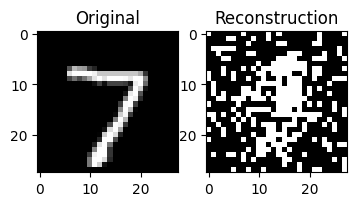

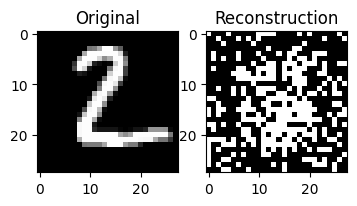

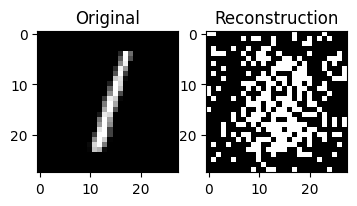

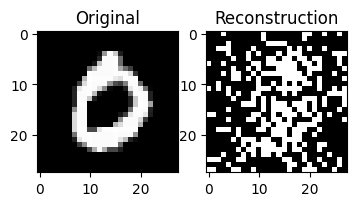

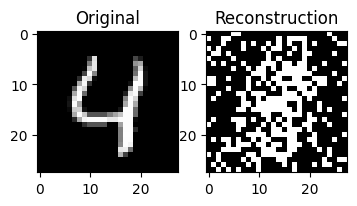

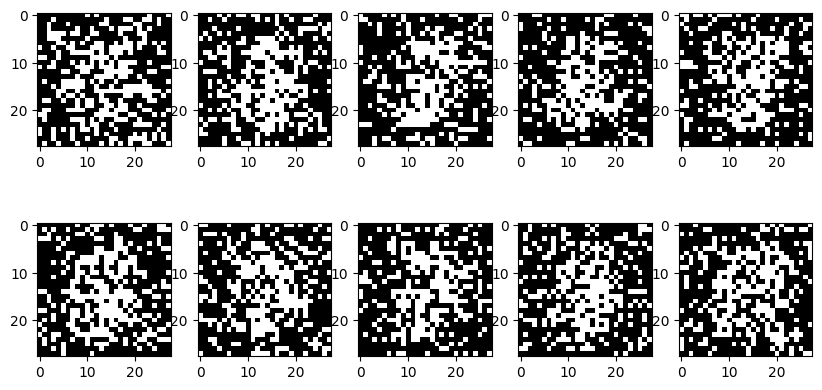

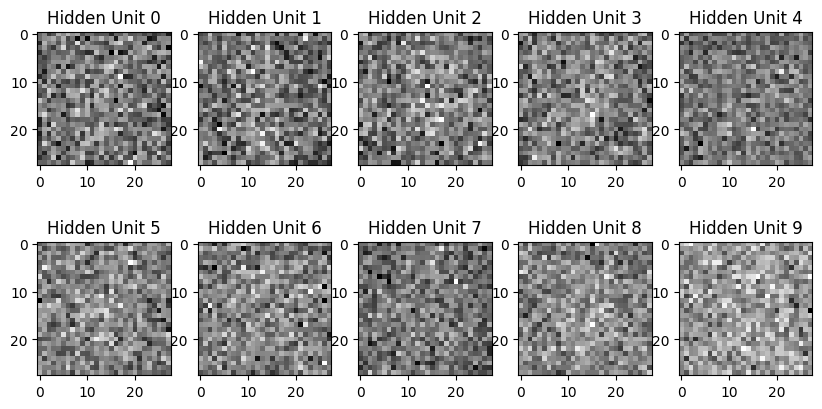

In [4]:
import matplotlib.pyplot as plt

# Evaluate on the test set
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

def evaluate(model, test_loader, k=1):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1)
            v_recon, h = model(data, k=k)
            test_loss += calculate_loss(data, v_recon, model, h).item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

evaluate(model, test_loader)

# Visualization functions
def visualize_reconstruction(model, data_loader, num_images=5):
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(data.size(0), -1)
            v_recon, _ = model(data)
            for i in range(num_images):
                plt.figure(figsize=(4, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(data[i].reshape(28, 28), cmap='gray')
                plt.title('Original')
                plt.subplot(1, 2, 2)
                plt.imshow(v_recon[i].reshape(28, 28), cmap='gray')
                plt.title('Reconstruction')
                plt.show()
            break

def generate_samples(model, num_samples=10, num_steps=100):
    with torch.no_grad():
        v = torch.bernoulli(torch.rand(num_samples, num_visible))
        for _ in range(num_steps):
            h = model.sample_h(v)
            v = model.sample_v(h)
        return v

def visualize_weights(model, num_weights=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_weights):
        plt.subplot(2, 5, i + 1)
        plt.imshow(model.W.detach().numpy()[i].reshape(28, 28), cmap='gray')
        plt.title(f'Hidden Unit {i}')
    plt.show()


# Visualizations
visualize_reconstruction(model, test_loader)
samples = generate_samples(model)
# Visualize the generated samples
plt.figure(figsize=(10, 5))
for i in range(len(samples)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
plt.show()
visualize_weights(model)
# Visual